In [2]:
#import pandas na sporacovanie excel
import pandas as pd
import random
import time
import requests
from datetime import datetime,timedelta
import numpy as np
import yfinance as yf
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import clear_output



#import md na vizualizáciu tabuliek
from IPython.display import Markdown as md

In [3]:
url= 'https://raw.githubusercontent.com/SimonPodstavek/XTBdata/master/helper.xlsx'
myfile = requests.get(url)

df=pd.read_excel(myfile.content,sheet_name='Sheet1')
df.columns =['Col_1', 'Col_2']

In [4]:
def get_prices(tickers, days):
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date=(datetime.today()-timedelta(days=days)).strftime('%Y-%m-%d')
    try:
        data = yf.download(tickers,start_date,end_date)['Adj Close']
        return data
    except:
        print(f"TICKER {t} je nedostupný alebo nemá dostatok časových údajov")

## Spracovácanie vstupov, výpočet Δadj.close DOD, Residuals X

# Výpočet kovariácie a pomocné výpočty

In [5]:
covariance=[]
def calculate_residual(data,number_of_tickers):
    number_records=df.shape[0]
    data_pct = data.pct_change()
    mean_pct = data_pct.mean(axis=0)
    data_pct_center = data_pct.sub(mean_pct, axis=1)
    
    residuals = data_pct_center.values.tolist()
    mean_pct=mean_pct.values.tolist()
    # mean_pct=mean_pct.values.tolist()
    residuals=residuals[1:]
    calculate_covariance(residuals,number_records,number_of_tickers,mean_pct)


def calculate_covariance(residuals,number_records,number_of_tickers,mean_pct):
    global covariance
    covariance=[]
    T_residuals=np.transpose(residuals)
    sum=0
    
    for stock_n in  range(number_of_tickers):
        covariance.append([])
        for i in range(number_of_tickers):
            for T_i in range(len(T_residuals[stock_n])-1):
                    # print(f'stock_n: {stock_n},T_i: {T_i}, i: {i}')
                    sum+=T_residuals[stock_n][T_i]*residuals[T_i][i]
            covariance[stock_n].append(sum/(number_days.value-1))
            sum=0
    # print(covariance)

    print(covariance)
    monte_carlo_simulation(number_portfolios.value,mean_pct,number_of_tickers)
    return 0
    

def monte_carlo_simulation(number_portfolios,mean_pct,number_of_tickers):
    global frontierData
    tophigh=0   
    highest=[]
    frontierData=[]
    loopi=0
    for each in range(number_portfolios):
        global covariance
        assetWeights=[]  
        weightscalc=[]
        basisPoint=0
        weightscalc=[random.random() for i in range(number_of_tickers)]
        basisPoint=1/(np.sum(weightscalc))
        for each in weightscalc:
            assetWeights.append(each*basisPoint) 

        # Výpočet smerodajne odchylky portfólia 1. krok, násobenie prvej matice
        covariancesFirstMultiple=[]
        i=0
        sum=0
        for column in range(len(covariance[0])):
            for weight in assetWeights:
                sum+=covariance[column][i]*assetWeights[i]
                i+=1
            i=0
            covariancesFirstMultiple.append(sum)

        portfolioVariance=[]
        T_assetWeights=np.transpose(assetWeights)
        sum=0
        for i in range(len(covariancesFirstMultiple)):
            sum+=covariancesFirstMultiple[i]*T_assetWeights[i]
        portfolioVariance.append(sum)
        if portfolioVariance[0]:
            portfolioStandardDeviation=portfolioVariance[0]**0.5
        expected_portfolio_returnX=[]
        expected_portfolio_returnX+=[mean_pct[i]*assetWeights[i] for i in range(len(mean_pct))]
        expected_portfolio_return=np.sum(expected_portfolio_returnX)
        modified_sharpe_ratio=(expected_portfolio_return)/portfolioStandardDeviation
        
        frontierData.append([])
        frontierData[loopi].append(expected_portfolio_return)
        frontierData[loopi].append(portfolioStandardDeviation)
        loopi+=1

# #Hľadanie najväćšieho sharpe ratio a zapisovanie dát pre graf
    

        if (modified_sharpe_ratio > tophigh):
            tophigh=modified_sharpe_ratio
            highest.append(assetWeights)
            time.sleep(0.000001)

    # print("---------------------------")
    # print(highest)\
    # print(expected_portfolio_return)
    # print(portfolioStandardDeviation)
    # print(frontierData)
    # frontierData.sort(key=lambda row: (row|[0]))

In [6]:
number_tickers = ipywidgets.IntSlider(value=2,min=2,max=6,step=1,description='Počet tickerov: ',disabled=False,continuous_update=True,orientation='horizontal',readout=True,)
number_portfolios = ipywidgets.IntSlider(value=500,min=10,max=1000,step=1,description='Simulovaných portfólií: ',disabled=False,continuous_update=False,orientation='horizontal',readout=True,)
number_days = ipywidgets.IntSlider(value=100,min=7,max=150,step=1,description='Počet dní:  ',disabled=False,continuous_update=False,orientation='horizontal',readout=True,)
run_button = ipywidgets.Button(description="Spusti")
show_chart_button = ipywidgets.Button(description="Zobraz výsledok")
display(number_portfolios, number_days)

def add_input_ticker(n):
    global ticker_textboxes
    ticker_textboxes = [ipywidgets.Text(value='',placeholder='Zadajte Ticker',description=f'Ticker {i}:',disabled=False) for i in range(1, n+1)]
    instructions = ipywidgets.widgets.HTML('Zadajte Ticker (napr. AAPL):')
    display(instructions,ipywidgets.VBox(ticker_textboxes))

ipywidgets.interact(add_input_ticker, n=number_tickers)


tickers_names=[]
def output(button):
    global tickers_names
    text_box_values = [text_box.value for text_box in ticker_textboxes]
    tickers_names=text_box_values
    text_box_values=text_box_values[:-1]
    
    number_of_tickers=2
    print(text_box_values)
    
    calculate_residual((get_prices(text_box_values,number_days.value)),number_of_tickers)
    plt.show()


    
    
def load_chart(a):
    
    with output:
        global tickers_names
        clear_output()
        
        frontierData.sort(key=lambda row: (row[0]))
        x=[]
        y=[]
        for each in frontierData:
            x.append(each[1])
            y.append(each[0])

        plt.plot(x, y, 'r.')
        plt.show()  
        
        assetWeights=[]  
        weightscalc=[]
        basisPoint=0
        weightscalc = {s: [ord(c) for c in s] for s in tickers_names}
        summed = [sum(weightscalc[s]) for s in tickers_names]
        # weightscalc=[random.random() for i in range(len(tickers_names))]
        basisPoint=1/(np.sum(summed))
        for each in summed:
            assetWeights.append(each*basisPoint) 
        x=pd.DataFrame(assetWeights,tickers_names)
        x.columns=["Optimálna alokácia"]
        display(x.head())
          
    
display(run_button,show_chart_button)
run_button.on_click(output)
show_chart_button.on_click(load_chart)

%matplotlib inline
output = ipywidgets.Output()
display(output)
        

IntSlider(value=500, continuous_update=False, description='Simulovaných portfólií: ', max=1000, min=10)

IntSlider(value=100, continuous_update=False, description='Počet dní:  ', max=150, min=7)

interactive(children=(IntSlider(value=2, description='Počet tickerov: ', max=6, min=2), Output()), _dom_classe…

Button(description='Spusti', style=ButtonStyle())

Button(description='Zobraz výsledok', style=ButtonStyle())

Output()

Smerodajná odchylka výnosu

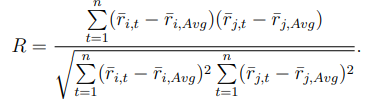

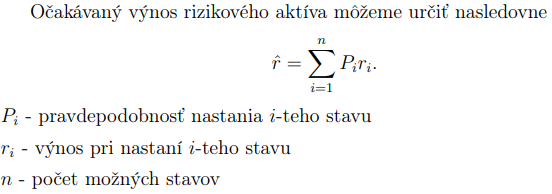

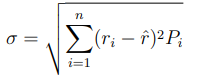

Kovarianca medzi dvoma aktívami

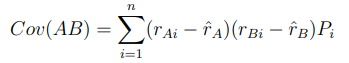

Korelácia výnosov dvoch aktív

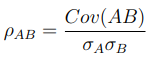